In [32]:
import pandas as pd
import requests
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('crop_yields.csv')

In [3]:
df.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2019,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,LOGAN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,194.2,NaN
1,SURVEY,2019,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,MACON,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,204.4,NaN
2,SURVEY,2019,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,MACON,...,NaN,NaN,0,NaN,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,63.8,NaN
3,SURVEY,2019,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,MARSHALL,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,184.9,NaN
4,SURVEY,2019,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,MARSHALL,...,NaN,NaN,0,NaN,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,53.8,NaN


In [4]:
df['County, State'] = df['County'] + ', ' + df['State']

In [5]:
unique_counties = list(df['County, State'].unique())

In [7]:
states = ['MO','IL','IA','KS','TX']
state_names = {'MO':'MISSOURI', 'IL':'ILLINOIS', 'IA':'IOWA', 'KS':'KANSAS', 'TX':'TEXAS'}
state_stations = {}

for state in states:
    state_stations[state] = {}
    response = requests.get(f'https://www.ncdc.noaa.gov//homr/services/station/search?state={state}&platform=ASOS')
    response_json = response.json()
    station_collection = response_json['stationCollection']['stations']
    for station in station_collection:
        state_name = state_names[state]
        for county in station['location']['geoInfo']['counties']:
            county_name = county['county']
            county_state = county_name + ', ' + state_name
            if county_state in unique_counties:
                station_id = station['identifiers'][0]['id']
                state_stations[state][station_id] = {'COUNTY':county_name,'STATE':state_name,'COUNTY_STATE':county_state}
            break

In [8]:
def get_data(year,stations):
    url = 'https://www.ncei.noaa.gov/access/services/data/v1'
    
    params = {
        'dataset':'daily-summaries',
        'startDate':f'{year}-01-01',
        'endDate':f'{year}-12-31',
        'format':'json',
        'includeStationLocation':1,
        'units':'standard',
        'stations':stations
    }
    
    response = requests.get(url, params)
    return response.json()

In [17]:
years = ['2000','2001','2002','2003','2004',
         '2005','2006','2007','2008','2009',
         '2010','2011','2012','2013','2014',
         '2015','2016','2017','2018','2019']
df_columns = ['FMTM','WSF2','STATION','WSF5','LONGITUDE',
              'ELEVATION','PRCP','DATE','WDF2','AWND',
              'WDF5','PGTM','TMAX','TAVG','TMIN','LATITUDE',
              'COUNTY_STATE','COUNTY','STATE'
             ]

In [18]:
weather_df = pd.DataFrame(columns=df_columns)
for state in states:
    stations = list(state_stations[state].keys())
    if len(stations) >= 50:
        stations = stations[:50]
    for year in years:
        clear_output(wait=True)
        print(f'{state}: {year}')
        year_df = pd.DataFrame(get_data(year,stations))
        year_df['COUNTY'] = [state_stations[state][station]['COUNTY'] for station in year_df['STATION']]
        year_df['STATE'] = [state_stations[state][station]['STATE'] for station in year_df['STATION']]
        year_df['COUNTY_STATE'] = [state_stations[state][station]['COUNTY_STATE'] for station in year_df['STATION']]
        filtered_df = year_df[[column for column in df_columns if column in year_df.columns]]
        
        weather_df = weather_df.append(filtered_df, ignore_index=True)
clear_output(wait=True)
print('Complete')

Complete


In [21]:
weather_df2 = weather_df.drop(columns=['FMTM','PGTM','TAVG'])

In [22]:
weather_df2 = weather_df2.dropna(how='any')

In [23]:
weather_df2 = weather_df2.reset_index(drop=True)

In [24]:
weather_df2['WSF2'] = weather_df2['WSF2'].astype('float')
weather_df2['WSF5'] = weather_df2['WSF5'].astype('float')
weather_df2['LONGITUDE'] = weather_df2['LONGITUDE'].astype('float')
weather_df2['ELEVATION'] = weather_df2['ELEVATION'].astype('float')
weather_df2['PRCP'] = weather_df2['PRCP'].astype('float')
weather_df2['DATE'] = pd.to_datetime(weather_df2['DATE'])
weather_df2['WDF2'] = weather_df2['WDF2'].astype('int')
weather_df2['AWND'] = weather_df2['AWND'].astype('float')
weather_df2['WDF5'] = weather_df2['WDF5'].astype('int')
weather_df2['TMAX'] = weather_df2['TMAX'].astype('int')
weather_df2['TMIN'] = weather_df2['TMIN'].astype('int')
weather_df2['LATITUDE'] = weather_df2['LATITUDE'].astype('float')

In [25]:
weather_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820087 entries, 0 to 820086
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   WSF2          820087 non-null  float64       
 1   STATION       820087 non-null  object        
 2   WSF5          820087 non-null  float64       
 3   LONGITUDE     820087 non-null  float64       
 4   ELEVATION     820087 non-null  float64       
 5   PRCP          820087 non-null  float64       
 6   DATE          820087 non-null  datetime64[ns]
 7   WDF2          820087 non-null  int32         
 8   AWND          820087 non-null  float64       
 9   WDF5          820087 non-null  int32         
 10  TMAX          820087 non-null  int32         
 11  TMIN          820087 non-null  int32         
 12  LATITUDE      820087 non-null  float64       
 13  COUNTY_STATE  820087 non-null  object        
 14  COUNTY        820087 non-null  object        
 15  STATE         820

In [26]:
weather_df2.head()

,WSF2,STATION,WSF5,LONGITUDE,ELEVATION,PRCP,DATE,WDF2,AWND,WDF5,TMAX,TMIN,LATITUDE,COUNTY_STATE,COUNTY,STATE
0,17.9,USW00013993,21.9,-94.9233,249.3,0.0,2000-01-01,160,8.50,190,60,30,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
1,28.0,USW00013993,33.1,-94.9233,249.3,0.0,2000-01-02,240,11.63,240,56,29,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
2,30.0,USW00013993,38.9,-94.9233,249.3,0.0,2000-01-03,360,14.09,360,37,30,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
3,25.9,USW00013993,31.1,-94.9233,249.3,0.0,2000-01-04,300,12.30,310,30,13,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
4,31.1,USW00013993,36.9,-94.9233,249.3,0.0,2000-01-05,200,12.75,210,49,16,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI


In [27]:
column_dict = {
    'WSF2':'Fastest 2-minute wind speed (MPH)',
    'WSF5':'Fastest 5-minute wind speed (MPH)',
    'PRCP':'Precipitation (Inches)',
    'WDF2':'Direction of fastest 2-minute wind speed',
    'WDF5':'Direction of fastest 5-minute wind speed',
    'AWND':'Average daily wind speed (MPH)',
    'TMAX':'Maximum temperature (F)',
    'TMIN':'Minimum temperature (F)'
}
weather_df2 = weather_df2.rename(columns=column_dict)

In [28]:
weather_df2.head()

,Fastest 2-minute wind speed (MPH),STATION,Fastest 5-minute wind speed (MPH),LONGITUDE,ELEVATION,Precipitation (Inches),DATE,Direction of fastest 2-minute wind speed,Average daily wind speed (MPH),Direction of fastest 5-minute wind speed,Maximum temperature (F),Minimum temperature (F),LATITUDE,COUNTY_STATE,COUNTY,STATE
0,17.9,USW00013993,21.9,-94.9233,249.3,0.0,2000-01-01,160,8.50,190,60,30,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
1,28.0,USW00013993,33.1,-94.9233,249.3,0.0,2000-01-02,240,11.63,240,56,29,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
2,30.0,USW00013993,38.9,-94.9233,249.3,0.0,2000-01-03,360,14.09,360,37,30,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
3,25.9,USW00013993,31.1,-94.9233,249.3,0.0,2000-01-04,300,12.30,310,30,13,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI
4,31.1,USW00013993,36.9,-94.9233,249.3,0.0,2000-01-05,200,12.75,210,49,16,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI


In [29]:
weather_df2.to_csv('aggregated_weather.csv', index=False)

In [40]:
weather_df2['year'] = [d.strftime('%Y') for d in weather_df2['DATE']]
weather_df2.head()

,Fastest 2-minute wind speed (MPH),STATION,Fastest 5-minute wind speed (MPH),LONGITUDE,ELEVATION,Precipitation (Inches),DATE,Direction of fastest 2-minute wind speed,Average daily wind speed (MPH),Direction of fastest 5-minute wind speed,Maximum temperature (F),Minimum temperature (F),LATITUDE,COUNTY_STATE,COUNTY,STATE,year
0,17.9,USW00013993,21.9,-94.9233,249.3,0.0,2000-01-01,160,8.50,190,60,30,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI,2000
1,28.0,USW00013993,33.1,-94.9233,249.3,0.0,2000-01-02,240,11.63,240,56,29,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI,2000
2,30.0,USW00013993,38.9,-94.9233,249.3,0.0,2000-01-03,360,14.09,360,37,30,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI,2000
3,25.9,USW00013993,31.1,-94.9233,249.3,0.0,2000-01-04,300,12.30,310,30,13,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI,2000
4,31.1,USW00013993,36.9,-94.9233,249.3,0.0,2000-01-05,200,12.75,210,49,16,39.7736,"BUCHANAN, MISSOURI",BUCHANAN,MISSOURI,2000


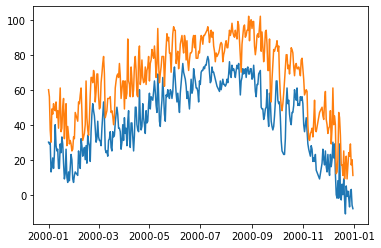

In [41]:
station = weather_df2['STATION'].unique()[0]
weather_to_graph = weather_df2.loc[(weather_df2['STATION'] == station) & (weather_df2['year'] == '2000')]
max_temp = weather_to_graph['Maximum temperature (F)']
min_temp = weather_to_graph['Minimum temperature (F)']
dates = weather_to_graph['DATE']

plt.plot(dates,min_temp)
plt.plot(dates,max_temp)